In [2]:
# loading the data
from pathlib import Path #for working with file system paths
import pandas as pd 
import tarfile #for reading and writing tar archives
import urllib.request #for fetching data from URLs

def load_housing_data():
    tar_path = Path("datasets/housing.tgz")
    if not tar_path.is_file() :
        Path("datasets").mkdir(parents=True, exist_ok=True) #creating the folder if not exist
        url= "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tar_path) #dowinloading dataset
        with tarfile.open(tar_path) as housing_tar:
            housing_tar.extractall(path="datasets") #extracting the tar file
    return pd.read_csv("datasets/housing/housing.csv")

housing = load_housing_data()

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

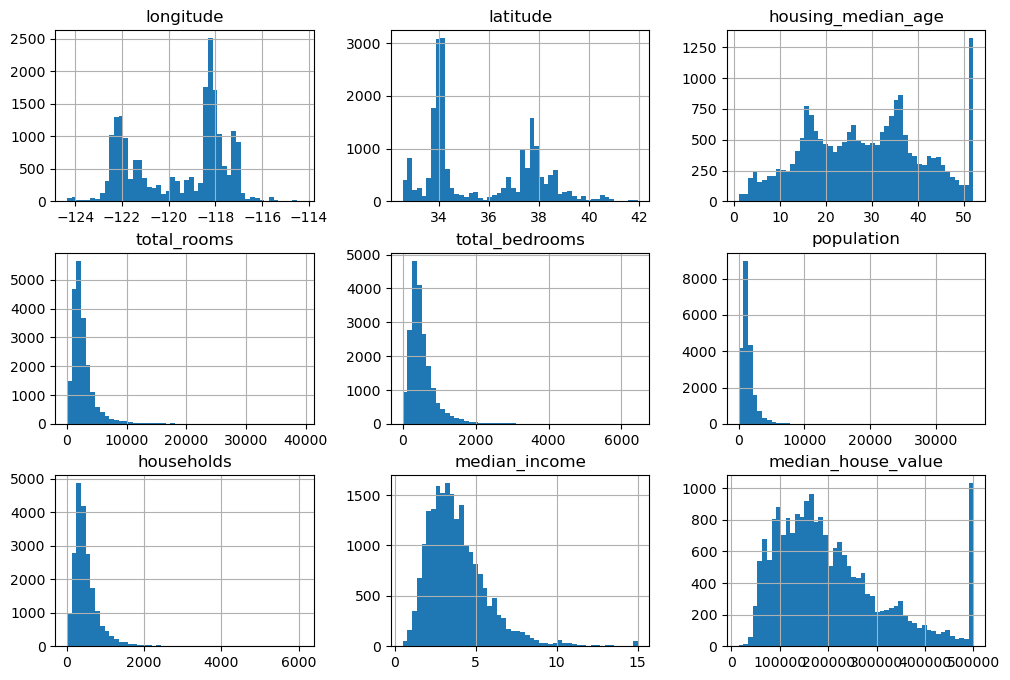

In [6]:
import matplotlib.pyplot as plt 

housing.hist(bins=50, figsize=(12, 8))
plt.show() 

In [7]:
import numpy as np

np.random.seed(42) #so it ganarates the same random indicies everytime

def shuffle_and_split(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)* test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train, test = shuffle_and_split(housing, 0.2)
len(train)

16512

In [8]:
#another way 
from sklearn.model_selection import train_test_split 
train, test = train_test_split(housing, test_size=0.2, random_state=42)

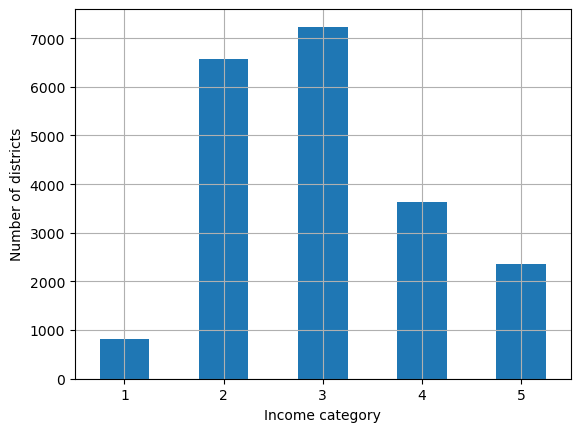

In [9]:
#applying startified sampling on the median income attribute
#assuming that it's very important for the prediction

housing["income_cat"] = pd.cut(housing["median_income"], 
                               bins=[0. , 1.5, 3.0, 4.5, 6., np.inf], 
                               labels=[1,2,3,4,5])

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid= True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [10]:
train, test =train_test_split(housing, test_size=0.2, random_state=42, stratify=housing["income_cat"])

In [11]:
for set_ in (train, test):
    set_.drop("income_cat", axis=1, inplace=True)

In [12]:
housing = test.copy()

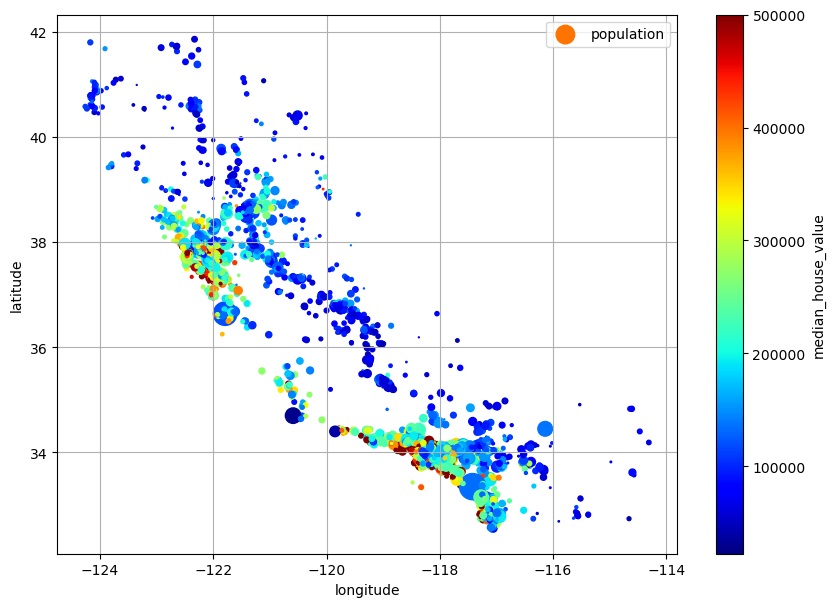

In [13]:
#ploting geographical information
#The radius of each circle represents the district’s population (option s),
#and the color represents the price (option c)
housing.plot(kind= "scatter", x= "longitude", y= "latitude", grid= True, 
             s= housing["population"]/100, label= "population",
             c= "median_house_value", cmap="jet", colorbar= True, legend= True,
             sharex= False, figsize= (10,7))
plt.show()

In [14]:
# Correlations
housing_numeric = housing.select_dtypes(include=[np.number])

corr_mtrx = housing_numeric.corr()
corr_mtrx["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687091
total_rooms           0.121070
housing_median_age    0.118976
households            0.043549
total_bedrooms        0.029600
longitude            -0.026768
population           -0.040286
latitude             -0.162087
Name: median_house_value, dtype: float64

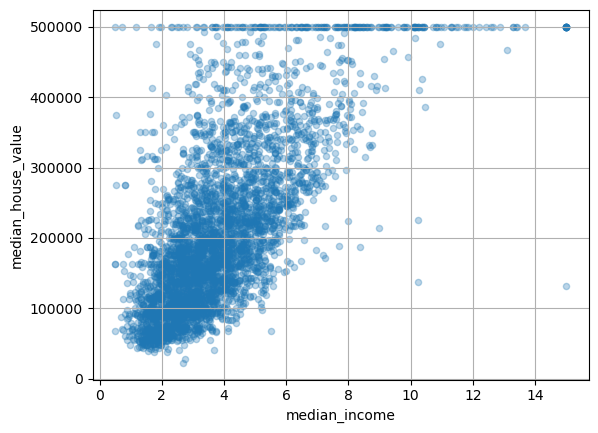

In [15]:
housing.plot(kind="scatter", x="median_income", 
    y="median_house_value", 
    alpha=0.3, grid=True)
plt.show()

In [16]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [17]:
housing_numeric = housing.select_dtypes(include=[np.number])

corr_mtrx = housing_numeric.corr()
corr_mtrx["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687091
rooms_per_house       0.198322
total_rooms           0.121070
housing_median_age    0.118976
households            0.043549
total_bedrooms        0.029600
people_per_house     -0.025974
longitude            -0.026768
population           -0.040286
latitude             -0.162087
bedrooms_ratio       -0.254506
Name: median_house_value, dtype: float64

In [18]:
#data cleaning

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")

In [19]:
housing_numeric = housing.select_dtypes(include=[np.number])

imputer.fit(housing_numeric)

SimpleImputer()

In [20]:
X = imputer.transform(housing_numeric)

In [21]:
#cause the transformer's output is a numpy array
housing_tr = pd.DataFrame(X, columns=housing_numeric.columns, index= housing_numeric.index)

In [22]:
housing_cat = housing[["ocean_proximity"]]

In [23]:
from sklearn.preprocessing import OrdinalEncoder
ord_encoder = OrdinalEncoder()
housing_cat_encoded = ord_encoder.fit_transform(housing_cat)

In [24]:
ord_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [25]:
#problrm: the ML algorithms will assume that two nearby values are more similar than two distant values.
from sklearn.preprocessing import OneHotEncoder

hot_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = hot_encoder.fit_transform(housing_cat)
housing_cat_1hot 

c:\Users\samam\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [30]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
housing_mmscaled = mmscaler.fit_transform(housing_numeric)

In [31]:
# Standrization
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler()
housing_sscaled = s_scaler.fit_transform(housing_numeric)